# Import Tensorflow

In [0]:
!pip install tensorflow==2.0.0b1

# Imports

In [0]:
# imports
import numpy as np
import os

from importlib import reload
from pkg_resources import resource_filename
from google.colab import drive
import imageio

In [0]:
import tensorflow
tensorflow.__version__

'2.0.0-beta1'

In [0]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!git clone https://github.com/pypeit/spit.git

Cloning into 'spit'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 845 (delta 108), reused 65 (delta 40), pack-reused 684
Receiving objects: 100% (845/845), 930.91 KiB | 821.00 KiB/s, done.
Resolving deltas: 100% (483/483), done.


In [0]:
%cd spit

/content/spit


In [0]:
!git checkout new_models

Branch 'new_models' set up to track remote branch 'new_models' from 'origin'.
Switched to a new branch 'new_models'


In [0]:
!git pull

Already up to date.


In [0]:
!python setup.py develop

running develop
running egg_info
creating spit.egg-info
writing spit.egg-info/PKG-INFO
writing dependency_links to spit.egg-info/dependency_links.txt
writing top-level names to spit.egg-info/top_level.txt
writing manifest file 'spit.egg-info/SOURCES.txt'
writing manifest file 'spit.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.6/dist-packages/spit.egg-link (link to .)
Adding spit 0.1.dev0 to easy-install.pth file
Installing spit_train script to /usr/local/bin
Installing spit_png script to /usr/local/bin
Installing spit_classify_image script to /usr/local/bin

Installed /content/spit
Processing dependencies for spit==0.1.dev0
Finished processing dependencies for spit==0.1.dev0


In [0]:
# imports
from importlib import reload

from spit import image_loader
from spit import labels
from spit import preprocess
from spit import classifier as c
from spit import utils

# Build DenseNet

In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
print(tf.test.is_gpu_available())
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

True
Found GPU at: /device:GPU:0


In [0]:
# need to add compression to either block, transition, or both to get it to be BC

def dense_block(model):
  
  # 1x1 convolution bottleneck
  
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU())
  #### HYPERPARAMETERS: GROWTH RATE AND DROPOUT RATE ####
  model.add(keras.layers.Conv2D(growth_rate*filters, kernel_size=1))
  model.add(keras.layers.Dropout(rate=dropout_rate))
  
  # 3x3 dense convolution
  
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU())
  #### HYPERPARAMETER ####
  model.add(keras.layers.Conv2D(filters, kernel_size=3))
  #### HYPERPARAMETER ####
  model.add(keras.layers.Dropout(rate=dropout_rate))
  
  return

def transition_layer(model):
  model.add(keras.layers.BatchNormalization())       #   x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
  model.add(keras.layers.ReLU())                     #   x = Relu(x)
  
  model.add(keras.layers.Conv2D(filters, kernel_size=1))
  
  model.add(keras.layers.Dropout(rate=dropout_rate)) #   x = Drop_out(x, rate=dropout_rate, training=self.training)
  
  model.add(keras.layers.AveragePooling2D(pool_size=(2,2), strides=2))
  return
  

In [0]:
#### DENSE NET ARCHITECTURE #####
#
# CONV --> BLOCK --> TRANSITION --> BLOCK --> TRANSITION --> BLOCK --> POOL --> SOFTMAX
#
# BLOCK:
# BatchNorm --> ReLu --> Conv (1x1) --> DropOut --> BatchNorm --> ReLu --> Conv (3x3) --> DropOut --> output
#

model = keras.Sequential()

# hyperparameters
filters = 64
dropout_rate = .2
theta = .5
growth_rate = 4

# add a conv layer
model.add(keras.layers.Conv2D(filters, kernel_size=7, strides=(2, 2), padding='valid', activation='relu', 
                            input_shape = (210, 650, 1)))

# pool like in tf simple implementation
model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'))

# add block
dense_block(model)
# add transition
transition_layer(model)
# add block
dense_block(model)
# add transition
transition_layer(model)
# add block
dense_block(model)
# add pool
model.add(keras.layers.GlobalAveragePooling2D())
# add flatten
model.add(keras.layers.Flatten())

# Produce 0-1 probabilities with softmax
model.add(keras.layers.Dense(5, activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Fake Data

In [0]:
x_train = np.random.random((100, 210, 650, 1))
train_labels = np.random.randint(5, size=(100, 1))

In [0]:
y_train = keras.utils.to_categorical(train_labels, num_classes=5)

In [0]:
 model.fit(
        x_train, 
        y_train, 
        epochs=5, 
        batch_size=6 
 )

Train on 100 samples
Epoch 1/5
 12/100 [==>...........................] - ETA: 2:54 - loss: 2.8118 - accuracy: 0.2500

KeyboardInterrupt: ignored

# Kast Training

In [0]:
os.environ['SPIT_PATH'] = "/content/drive/My Drive/Colab Notebooks/SPIT_DATA"
os.environ['SAVE_PATH'] = "/content/drive/My Drive/Colab Notebooks/"

In [0]:
label_dict = labels.kast_label_dict()
preproc_dict = preprocess.original_preproc_dict()
classify_dict = labels.kast_classify_dict(label_dict)

# kast = c.Classifier(label_dict, preproc_dict, classify_dict)

In [0]:
history = _train(epochs=5, batch_size=6, subset_percent = .05, test_model=model)

Train on 775 samples, validate on 190 samples
Epoch 1/5
774/775 [============================>.] - ETA: 0s - loss: 1.0628 - accuracy: 0.6137

W0725 01:17:44.021348 140479997958016 callbacks.py:986] Can save best model only with val_acc available, skipping.


775/775 [==============================] - 397s 513ms/sample - loss: 1.0643 - accuracy: 0.6129 - val_loss: 6.3602 - val_accuracy: 0.3105
Epoch 2/5
774/775 [============================>.] - ETA: 0s - loss: 0.7081 - accuracy: 0.7636

W0725 01:24:15.517875 140479997958016 callbacks.py:986] Can save best model only with val_acc available, skipping.


775/775 [==============================] - 391s 505ms/sample - loss: 0.7103 - accuracy: 0.7626 - val_loss: 5.7390 - val_accuracy: 0.2737
Epoch 3/5
774/775 [============================>.] - ETA: 0s - loss: 0.6472 - accuracy: 0.7894

W0725 01:30:46.915717 140479997958016 callbacks.py:986] Can save best model only with val_acc available, skipping.


775/775 [==============================] - 391s 505ms/sample - loss: 0.6493 - accuracy: 0.7884 - val_loss: 2.6473 - val_accuracy: 0.7474
Epoch 4/5
774/775 [============================>.] - ETA: 0s - loss: 0.4367 - accuracy: 0.8592

W0725 01:37:19.759352 140479997958016 callbacks.py:986] Can save best model only with val_acc available, skipping.


775/775 [==============================] - 393s 507ms/sample - loss: 0.4405 - accuracy: 0.8581 - val_loss: 3.0710 - val_accuracy: 0.6053
Epoch 5/5
774/775 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9432

W0725 01:43:51.642585 140479997958016 callbacks.py:986] Can save best model only with val_acc available, skipping.


775/775 [==============================] - 392s 506ms/sample - loss: 0.1941 - accuracy: 0.9419 - val_loss: 0.9323 - val_accuracy: 0.8579


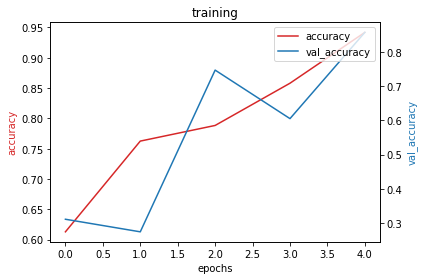

In [0]:

utils.display_training_trends(history, key1='accuracy', key2='val_accuracy')

# train methods

In [0]:
  os.environ['SPIT_PATH'] = "/content/drive/My Drive/Colab Notebooks/SPIT_DATA"
  os.environ['SAVE_PATH'] = "/content/drive/My Drive/Colab Notebooks/"

  # might need to add subset
  def _train(epochs, batch_size, subset_percent=None, train_images=None, train_labels=None, validation_data=None, steps_per_epoch=None, validation_freq=1, test_model=None, spit_path=os.getenv('SPIT_PATH'), save_path=os.getenv('SAVE_PATH')):
    """

    Trains the classifier with given images, labels, and training parameters.

    Parameters:

    :param epochs:
      Number of epochs of the training. 
      Must be an integer value.

    :param batch_size:
      Size of the training batches formed in the process. 
      Must be an integer value.

    :param save_path:
      Path to where the best model will be saved.

    :param train_images:
       Set of images for model to train on.
       Assume this is a numpy array with (batch_size, width, height, num_channels) as its dimensions.

    :param train_labels:
      Set of test labels corresponding to test images.
      Assume this is a rank 1 array with (batch_size, ) as its dimensions.

    :param validation_data:
      Data to be used for the validation set. 
      Assume this is a tuple with (images, labels) with same dimensions as train_images, train_labels.
      If None is specified, validation_data will be None.

    :param steps_per_epoch:
      Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.
      Assume this is an integer value. If None is specified, this will be None.  

    :param validation_freq:
      Specifies how many training epochs to run before a new validation run is performed.
      Assume this is an integer value or a collection containing the epochs at which to run validation (ie [1,2,10]).

    :param test_model:
      An alternative choice for model to train on. Assume None.

    :param spit_path & param save_path:
      Path to the spit images and where the model will be saved respectively.
      ***Environmental variables must be set by caller or the path must be passed manually.***

    Returns:
    :returns history:
      Tensorflow History object containing loss and accuracy data over the training.

    """
    # choose the model
    if test_model is None:
      model = test_model
    else:
      model = test_model

    # if None is passed, then use the kast images
    if train_images is None or train_labels is None:
      # load training set
      train = np.load(os.path.join(spit_path, 'Kast', 'kast_train.npz'))
      train_images = train['images']
      train_labels = train['labels']

      # load validation set
      validate = np.load(os.path.join(spit_path, 'Kast', 'kast_validate.npz'))
      v_images = validate['images']
      v_labels = validate['labels']

      validation_data = (v_images, v_labels)

    # change to categorical and make subsets
    if validation_data is not None:
      valid_images, valid_labels = validation_data
      if subset_percent is not None:
        valid_images, valid_labels = split_array(valid_images, valid_labels, subset_percent)
      valid_labels = keras.utils.to_categorical(valid_labels, num_classes=len(label_dict))
      validation_data = (valid_images, valid_labels)

    if train_images is not None and train_labels is not None:
      if subset_percent is not None:
        train_images, train_labels = split_array(train_images, train_labels, subset_percent)
      train_labels = keras.utils.to_categorical(train_labels, num_classes=len(label_dict))

    # checkpoint to track best model
    checkpoint=keras.callbacks.ModelCheckpoint(save_path+'best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # train the model
    history = model.fit(
          train_images, 
          train_labels, 
          epochs=epochs, 
          batch_size=batch_size,
          validation_data=validation_data,
          steps_per_epoch=steps_per_epoch,
          validation_freq=validation_freq,
          callbacks=[checkpoint]
    )
    # loss and accuracy data
    keys = history.history
    # save to disc differently based on whether validation set was used
    np.savez_compressed('history.npz', loss=keys['loss'], accuracy=keys['accuracy'], val_loss=keys['val_loss'], val_acc=keys['val_accuracy'])

    return history

  import math

  def split_array(images, labels, subset_percent):
    """
    Splits dataset based on a percentage value.

    Parameters:
    :param images:
      Images from a dataset to be trained on.
      4-D Numpy array with (batch_size, width, height, num_channels) as its dimensions.

    :param labels:
      Labels from a dataset to be trained on.
      Rank 1 Numpy array with (batch_size,) as its dimensions.

    :param subset_percent:
      Float value determining percentage of subset to remain.

    Returns:
    :returns split_images:
      Numpy array containing a fraction of the initial images parameter (batch_size*subset_percent)

    :returns split_labels:
      Numpy array containing a fraction of the initial labels parameter (batch_size*subset_percent)
    """
    split_images = []
    split_labels = []
    
    # get all unique labels
    uni_lbls = np.unique(labels)
    
    # find all instances of labels and subset based on that
    for uni_lbl in uni_lbls:
      idx = np.where(labels==uni_lbl)[0]
      # 0 : len(idx)*subset_percent
      lower = 0
      upper = int(math.floor(len(idx)*subset_percent))
      split_images.extend(images[idx[lower:upper]])
      split_labels.extend(labels[idx[lower:upper]])
    return np.asarray(split_images), np.asarray(split_labels)

In [0]:
history = _train(epochs=5, batch_size=6, subset_percent = .10, test_model=model)

Train on 1550 samples, validate on 385 samples
Epoch 1/5
1548/1550 [============================>.] - ETA: 0s - loss: 0.8283 - accuracy: 0.7132

W0725 02:12:07.126094 140479997958016 callbacks.py:986] Can save best model only with val_acc available, skipping.


1550/1550 [==============================] - 804s 518ms/sample - loss: 0.8318 - accuracy: 0.7129 - val_loss: 2.4794 - val_accuracy: 0.6026
Epoch 2/5
1548/1550 [============================>.] - ETA: 0s - loss: 0.4317 - accuracy: 0.8521

W0725 02:25:34.083913 140479997958016 callbacks.py:986] Can save best model only with val_acc available, skipping.


1550/1550 [==============================] - 807s 521ms/sample - loss: 0.4316 - accuracy: 0.8523 - val_loss: 1.0222 - val_accuracy: 0.6857
Epoch 3/5
1548/1550 [============================>.] - ETA: 0s - loss: 0.3266 - accuracy: 0.8908

W0725 02:38:58.051750 140479997958016 callbacks.py:986] Can save best model only with val_acc available, skipping.


1550/1550 [==============================] - 804s 519ms/sample - loss: 0.3352 - accuracy: 0.8897 - val_loss: 11.9028 - val_accuracy: 0.2416
Epoch 4/5
1548/1550 [============================>.] - ETA: 0s - loss: 0.3403 - accuracy: 0.8986

W0725 02:52:19.755737 140479997958016 callbacks.py:986] Can save best model only with val_acc available, skipping.


1550/1550 [==============================] - 802s 517ms/sample - loss: 0.3400 - accuracy: 0.8987 - val_loss: 4.3981 - val_accuracy: 0.5273
Epoch 5/5
1548/1550 [============================>.] - ETA: 0s - loss: 0.2231 - accuracy: 0.9315

W0725 03:05:29.237051 140479997958016 callbacks.py:986] Can save best model only with val_acc available, skipping.


1550/1550 [==============================] - 789s 509ms/sample - loss: 0.2228 - accuracy: 0.9316 - val_loss: 0.2768 - val_accuracy: 0.8883


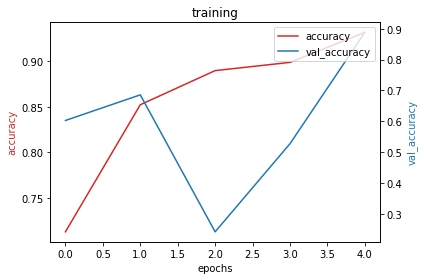

In [0]:
utils.display_training_trends(history, key1='accuracy', key2='val_accuracy')

In [0]:
history = _train(epochs=6, batch_size=6, test_model=model)

Train on 15540 samples, validate on 3880 samples
Epoch 1/6
15534/15540 [============================>.] - ETA: 3s - loss: 0.2863 - accuracy: 0.9102

W0725 05:36:21.985853 140479997958016 callbacks.py:986] Can save best model only with val_acc available, skipping.


15540/15540 [==============================] - 8232s 530ms/sample - loss: 0.2862 - accuracy: 0.9102 - val_loss: 0.9629 - val_accuracy: 0.8585
Epoch 2/6
13482/15540 [=========================>....] - ETA: 17:26 - loss: 0.1069 - accuracy: 0.9684

In [0]:
history = _train(epochs=5, batch_size=6, test_model=model)

W0725 08:30:08.438622 140174057060224 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15540 samples, validate on 3880 samples
Epoch 1/5
15534/15540 [============================>.] - ETA: 2s - loss: 0.2652 - accuracy: 0.9178

W0725 10:45:40.559539 140174057060224 callbacks.py:986] Can save best model only with val_acc available, skipping.


15540/15540 [==============================] - 8128s 523ms/sample - loss: 0.2651 - accuracy: 0.9178 - val_loss: 0.0916 - val_accuracy: 0.9807
Epoch 2/5
15534/15540 [============================>.] - ETA: 2s - loss: 0.1222 - accuracy: 0.9671

W0725 12:58:31.137780 140174057060224 callbacks.py:986] Can save best model only with val_acc available, skipping.


15540/15540 [==============================] - 7971s 513ms/sample - loss: 0.1221 - accuracy: 0.9671 - val_loss: 0.0558 - val_accuracy: 0.9853
Epoch 3/5
15534/15540 [============================>.] - ETA: 2s - loss: 0.0862 - accuracy: 0.9764

W0725 15:08:45.694696 140174057060224 callbacks.py:986] Can save best model only with val_acc available, skipping.


15540/15540 [==============================] - 7815s 503ms/sample - loss: 0.0862 - accuracy: 0.9764 - val_loss: 0.1374 - val_accuracy: 0.9796
Epoch 4/5
15534/15540 [============================>.] - ETA: 2s - loss: 0.0669 - accuracy: 0.9832

W0725 17:17:37.540996 140174057060224 callbacks.py:986] Can save best model only with val_acc available, skipping.


15540/15540 [==============================] - 7732s 498ms/sample - loss: 0.0668 - accuracy: 0.9832 - val_loss: 0.0720 - val_accuracy: 0.9784
Epoch 5/5
15534/15540 [============================>.] - ETA: 2s - loss: 0.0647 - accuracy: 0.9835

W0725 19:27:23.475267 140174057060224 callbacks.py:986] Can save best model only with val_acc available, skipping.


15540/15540 [==============================] - 7786s 501ms/sample - loss: 0.0647 - accuracy: 0.9835 - val_loss: 0.1236 - val_accuracy: 0.9678


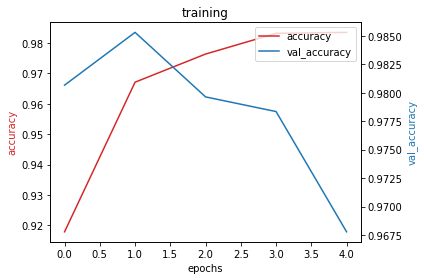

In [0]:
utils.display_training_trends(history, key1='accuracy', key2='val_accuracy')

In [0]:
from tensorflow import keras
# need to add compression to either block, transition, or both to get it to be BC

def dense_block(model):
  
  # 1x1 convolution bottleneck
  
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU())
  #### HYPERPARAMETERS: GROWTH RATE AND DROPOUT RATE ####
  model.add(keras.layers.Conv2D(growth_rate*filters, kernel_size=1))
  model.add(keras.layers.Dropout(rate=dropout_rate))
  
  # 3x3 dense convolution
  
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU())
  #### HYPERPARAMETER ####
  model.add(keras.layers.Conv2D(filters, kernel_size=3))
  #### HYPERPARAMETER ####
  model.add(keras.layers.Dropout(rate=dropout_rate))
  
  return

def transition_layer(model):
  model.add(keras.layers.BatchNormalization())       #   x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
  model.add(keras.layers.ReLU())                     #   x = Relu(x)
  
  model.add(keras.layers.Conv2D(filters, kernel_size=1))
  
  model.add(keras.layers.Dropout(rate=dropout_rate)) #   x = Drop_out(x, rate=dropout_rate, training=self.training)
  
  model.add(keras.layers.AveragePooling2D(pool_size=(2,2), strides=2))
  return

model = keras.Sequential()

# hyperparameters
filters = 64
dropout_rate = .2
theta = .5
growth_rate = 4

# add a conv layer
model.add(keras.layers.Conv2D(filters, kernel_size=7, strides=(2, 2), padding='valid', activation='relu', 
                            input_shape = (210, 650, 1)))

# pool like in tf simple implementation
model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'))

# add block
dense_block(model)
# add transition
transition_layer(model)
# add block
dense_block(model)
# add transition
transition_layer(model)
# add block
dense_block(model)
# add pool
model.add(keras.layers.GlobalAveragePooling2D())
# add flatten
model.add(keras.layers.Flatten())

# Produce 0-1 probabilities with softmax
model.add(keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 102, 322, 64)      3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 160, 64)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 160, 64)       256       
_________________________________________________________________
re_lu (ReLU)                 (None, 50, 160, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 160, 256)      16640     
_________________________________________________________________
dropout (Dropout)            (None, 50, 160, 256)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 160, 256)      1